# Content Based Filtering

In [29]:
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt

from ast import literal_eval
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.preprocessing import MinMaxScaler

## TMDB Movie Data

In [2]:
credits = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_credits.csv')
movies = pd.read_csv('datasets/tmdb_5000_movie_dataset/tmdb_5000_movies.csv')

In [3]:
credits.sample(1)

,movie_id,title,cast,crew
597,52520,Underworld: Awakening,"[{""cast_id"": 1, ""character"": ""Selene"", ""credit...","[{""credit_id"": ""52fe4830c3a36847f815bcb3"", ""de..."


In [4]:
movies.sample(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
71,145000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://www.themummy.com/,1735,[],en,The Mummy: Tomb of the Dragon Emperor,"Archaeologist Rick O'Connell travels to China,...",60.034162,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2008-07-01,401128639,112.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,A New Evil Awakens.,The Mummy: Tomb of the Dragon Emperor,5.2,1387


In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

## Data Exploration

In [6]:
# Rename column movie_id to id and then merging the two dataframe together on id
credits = credits.rename({'movie_id': 'id'}, axis = 1)
df = movies.merge(credits, on = 'id')

In [7]:
df = df.drop_duplicates()

In [8]:
df.shape

(4803, 23)

In [9]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

There are a lot of null values for the columns *homepage* and *tagline*. Fortunately those columns are not very important in terms of the metadata for the movies because *homepage* is just link to the movie and *tagline* is a catchphrase for a movie. Instead of *tagline* it will be much more useful to use the overview of the movies to see if movies are similar or not

In [10]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title_x                  object
vote_average            float64
vote_count                int64
title_y                  object
cast                     object
crew                     object
dtype: object

In [11]:
# Get Earlies and Latest Release Dates
df['release_date'] = pd.to_datetime(df['release_date'])
print("Earliest Release Date in dataset: " + str(min(df.release_date)))
print("Latest Release Date in dataset: " + str(max(df.release_date)))

Earliest Release Date in dataset: 1916-09-04 00:00:00
Latest Release Date in dataset: 2017-02-03 00:00:00


Text(0, 0.5, 'frequency')

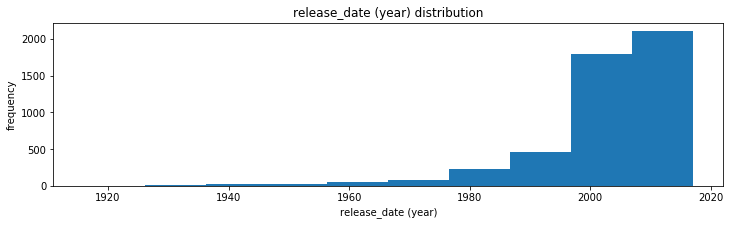

In [12]:
# Distribution of release years 
fig = plt.figure(figsize = (12,3))
plt.hist(df.release_date.dt.year)
plt.title('release_date (year) distribution')
plt.xlabel('release_date (year)')
plt.ylabel('frequency')

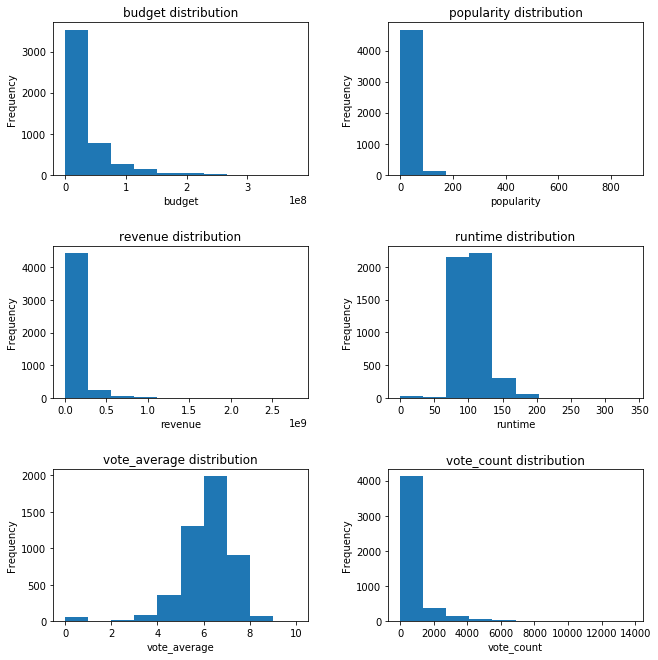

In [13]:
continuous_features = ['budget', 'popularity', 'revenue', 'runtime',
                      'vote_average', 'vote_count']

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = [10 ,10])
fig.tight_layout(pad = 5.0)
axes = axes.flatten()
position = 0
for feature in continuous_features:
    axes[position].hist(df[feature])
    axes[position].set_title(feature + " distribution")
    axes[position].set_xlabel(feature)
    axes[position].set_ylabel("Frequency")
    position = position + 1

## Simple Recommender

The simplest recommender system we can build is one that doesn't even use the metadata of the movie; recommends movies based off top-rated or popularity. This is a simple approach to recommending as movies that are popular or more highly rated will have a higher probability of being liked by the average audience.

### Recommendations Using Popularity

#### Popularity

In [16]:
df.sort_values('popularity', ascending = False)[['original_title', 'release_date','popularity']].head(10)

,original_title,release_date,popularity
546,Minions,2015-06-17,875.581305
95,Interstellar,2014-11-05,724.247784
788,Deadpool,2016-02-09,514.569956
94,Guardians of the Galaxy,2014-07-30,481.098624
127,Mad Max: Fury Road,2015-05-13,434.278564
28,Jurassic World,2015-06-09,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,2003-07-09,271.972889
82,Dawn of the Planet of the Apes,2014-06-26,243.791743
200,The Hunger Games: Mockingjay - Part 1,2014-11-18,206.227151
88,Big Hero 6,2014-10-24,203.734590


### Recommendations Using Rating

#### Weighted Rating

From our data we have a *vote_average* feature. The *vote_average* feature is just the average rating given for that movie. This feature is a little deceiving. Just because a movie has a higher *vote_average* score than another, it does not necessarily mean it is better. This is because we need to take into the consideration the number of votes a movie has received. A movie with a *vote_average* of 8 and *vote_count* of 10 is not necessarily a better movie than one that has a *vote_average* of 7.5, but 1000 votes.

In [23]:
df.sort_values('vote_average', ascending = False)[['original_title', 'vote_count', 'vote_average']].head(10)

,original_title,vote_count,vote_average
3519,Stiff Upper Lips,1,10.0
4247,Me You and Five Bucks,2,10.0
4045,"Dancer, Texas Pop. 81",1,10.0
4662,Little Big Top,1,10.0
3992,Sardaarji,2,9.5
2386,One Man's Hero,2,9.3
2970,There Goes My Baby,2,8.5
1881,The Shawshank Redemption,8205,8.5
2796,The Prisoner of Zenda,11,8.4
3337,The Godfather,5893,8.4


**IMDB** uses a weighted rating for their movies. The formula for the weighted rating is:

$$WR = (\frac{v}{v + m})R + (\frac{m}{v + m})C$$

* R - average rating for the movie (the *vote_average* column)
* v - number of votes for the movie (the *vote_count* column)
* m - minimum votes required to be listed (need to calculate this)
* C - average vote across entire data (need to calculate this)

In [19]:
c = df['vote_average'].mean()
m = df['vote_count'].quantile(0.90)
df_top_rated = df.copy().loc[df['vote_count'] >= m]
print(df_top_rated.shape)

(481, 23)


In [20]:
def weighted_rating(movie, m=m, c=c):
    R = movie['vote_average']
    v = movie['vote_count']
    
    weighted_rate = (v/(v+m)*R) + (m/(m+v)*c)
    return weighted_rate
    
df_top_rated['weighted_rating'] = df_top_rated.apply(weighted_rating, axis = 1)

In [22]:
df_top_rated.sort_values('weighted_rating', ascending = False)[['original_title', 'weighted_rating']].head(10)

,original_title,weighted_rating
1881,The Shawshank Redemption,8.059258
662,Fight Club,7.939256
65,The Dark Knight,7.920020
3232,Pulp Fiction,7.904645
96,Inception,7.863239
3337,The Godfather,7.851236
95,Interstellar,7.809479
809,Forrest Gump,7.803188
329,The Lord of the Rings: The Return of the King,7.727243
1990,The Empire Strikes Back,7.697884


This is a really simple recommender system. It is recommending based on what are the best movies.

**Advantages** of these simple recommender systems:
* You don't any sort of user rating or information to make recommendations.
* Solves the cold-start problem

**Disadvantages** of these simple recommender systems:
* There is no personalization. Recommends the same movies to everyone

## Content-Based Filtering

### Recommendations Using the Overview

#### Term Frequency - Inverse Document Frequency (TF-IDF) On Movie Overview

We can use the *overview* column to help make recommendations. If you enjoy a movie, it is very likely you will enjoy another one with similar plot or overview.

How do we calculate the similarity between two plots? We need to convert the *overview* from a sequence of words into numbers which we can then use to calculate some sort of similarity score.

We will be using **TF-IDF** to convert the *overviews* into numbers. It calculates a score for each word in the corpus of words.

* Term Frequency - is the number of occurences of a specific term in a document (overviews).
* Document Frequency - is the number of documents (overviews) containing a specific word. This indicates how common the word is.
* Inverse Document Frequency is the weight of the word. If the word appears often throughout the movie dataset, then it does not have much weight.

$$w_{i,j} = tf_{i,j} x idf_i$$

where:

$$idf_i = log(\frac{n}{df_i})$$

In [27]:
# remove stopwords. Stopwords are common words that add no meaning to the text
tfidf = TfidfVectorizer(stop_words = 'english')

overview_matrix = tfidf.fit_transform(df['overview'].values.astype('str'))

In [28]:
overview_matrix.shape

(4803, 20979)

The shape of the tfidf matrix tells us that 20979 unique words (after removing stopwords) were used to described the 4803 movies. 

In [34]:
df_test = df.copy()
df_test['tfidf'] = list(overview_matrix.toarray())

In [36]:
df_test[['original_title', 'tfidf']]

,original_title,tfidf
0,Avatar,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Pirates of the Caribbean: At World's End,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Spectre,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,The Dark Knight Rises,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,John Carter,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
4798,El Mariachi,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4799,Newlyweds,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4800,"Signed, Sealed, Delivered","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4801,Shanghai Calling,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Cosine Similarity

In [31]:
cosine_score = linear_kernel(overview_matrix, overview_matrix)

In [46]:
cosine_score

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160533, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01488159, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160533, 0.01488159, ..., 1.        , 0.01609091,
        0.00701914],
       [0.        , 0.        , 0.        , ..., 0.01609091, 1.        ,
        0.01171696],
       [0.        , 0.        , 0.        , ..., 0.00701914, 0.01171696,
        1.        ]])

In [40]:
cosine_df = pd.DataFrame(cosine_score, columns = df.original_title.values.tolist())
cosine_df.index = df.original_title.values.tolist()

In [45]:
cosine_df.head()

,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
Avatar,1.000000,0.000000,0.0,0.024995,0.000000,0.030353,0.000000,0.037581,0.000000,0.000000,...,0.000000,0.0,0.029175,0.042176,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Pirates of the Caribbean: At World's End,0.000000,1.000000,0.0,0.000000,0.033369,0.000000,0.000000,0.022676,0.000000,0.000000,...,0.000000,0.0,0.006895,0.000000,0.000000,0.0,0.0,0.021605,0.000000,0.000000
Spectre,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.030949,0.024830,0.000000,...,0.027695,0.0,0.000000,0.000000,0.017768,0.0,0.0,0.014882,0.000000,0.000000
The Dark Knight Rises,0.024995,0.000000,0.0,1.000000,0.010433,0.005145,0.012601,0.026954,0.020652,0.133740,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.033864,0.042752,0.022692
John Carter,0.000000,0.033369,0.0,0.010433,1.000000,0.000000,0.009339,0.037407,0.000000,0.017148,...,0.012730,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.006126,0.000000,0.000000


In [59]:
sorted(list(enumerate(cosine_score[0])), key = lambda x: x[1], reverse = True)

[(0, 1.0),
 (3604, 0.18681001056212054),
 (2130, 0.17015105119162663),
 (634, 0.13230696630317224),
 (1341, 0.12393264590871879),
 (529, 0.12248959164893028),
 (1610, 0.10469903037615635),
 (311, 0.10091388184065117),
 (847, 0.09799623121705058),
 (775, 0.09447938436890335),
 (2628, 0.09313854469530522),
 (942, 0.0924514241892011),
 (1033, 0.08753936247200367),
 (2767, 0.0818486532344246),
 (570, 0.08077097525490028),
 (1213, 0.07871095243967652),
 (2967, 0.07678602071424366),
 (2875, 0.07644276205946182),
 (3070, 0.07624478735120209),
 (36, 0.07454624070840556),
 (1013, 0.0744420990745722),
 (4211, 0.07329392043813658),
 (3724, 0.07307988854131138),
 (1274, 0.07230185082235971),
 (1784, 0.07176095764781792),
 (3970, 0.07138284265967441),
 (2578, 0.07063238531821642),
 (1959, 0.07011201811048635),
 (281, 0.0699103290579774),
 (150, 0.06865963374809526),
 (1345, 0.0676133596560152),
 (312, 0.0671326953894372),
 (3458, 0.06589361955408915),
 (151, 0.06547158879247776),
 (2614, 0.06516707

In [51]:
cosine_df.iloc[0]

Avatar                                      1.000000
Pirates of the Caribbean: At World's End    0.000000
Spectre                                     0.000000
The Dark Knight Rises                       0.024995
John Carter                                 0.000000
                                              ...   
El Mariachi                                 0.000000
Newlyweds                                   0.000000
Signed, Sealed, Delivered                   0.000000
Shanghai Calling                            0.000000
My Date with Drew                           0.000000
Name: Avatar, Length: 4803, dtype: float64

In [72]:
movie_index = pd.Series(df.index, index = df['original_title'])
movie_titles = df['original_title']

In [68]:
movie_titles[0]

'Avatar'

In [86]:
def recommend_movie(movie):
    # get the index of the movie
    index = movie_index[movie]
    # convert into a list of movie index and similarity values
    similarity = list(enumerate(cosine_score[index]))
    # sort list by the similarity value
    similarity = sorted(similarity, key = lambda x: x[1], reverse = True)
    # Get the top 10 most similar movies. Exclude the first value because it is itself.
    similarity = similarity[1:11]
    recommended_index = [i[0] for i in similarity] 
    recommended_title = [movie_titles[i] for i in recommended_index]
    recommended_score = [i[1] for i in similarity]
    return pd.DataFrame({'Recommended_Movie': recommended_title,
                         'Score': recommended_score})
    

In [92]:
recommend_movie('Avatar')

,Recommended_Movie,Score
0,Apollo 18,0.186810
1,The American,0.170151
2,The Matrix,0.132307
3,Obitaemyy Ostrov,0.123933
4,Tears of the Sun,0.122490
5,Hanna,0.104699
6,The Adventures of Pluto Nash,0.100914
7,Semi-Pro,0.097996
8,Supernova,0.094479
9,Blood and Chocolate,0.093139


### Recommendations Using Movies Features

In [211]:
df.sample(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
782,60000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 35, ""nam...",http://www.mycityscreams.com/,8285,"[{""id"": 1308, ""name"": ""secret identity""}, {""id...",en,The Spirit,Down these mean streets a man must come. A her...,14.84856,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,I'm gonna kill you all kinds of dead.,The Spirit,4.7,320,The Spirit,"[{""cast_id"": 6, ""character"": ""The Spirit/Denny...","[{""credit_id"": ""52fe449cc3a36847f809fee7"", ""de..."


In [212]:
df.iloc[0]

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                          2009-12-10 00:00:00
revenue                                                        2787965087
runtime                               

The following columns in the dataset contain lists of dictionaries as their values: *genres, keywords, production_companies, production_countries, spoken_languages, cast, crew*. 

We will extract the important medadata from these dictionaries and have the values in a list. 

For example, for the genre column we want the final output to look like this: [action, comedy].

We will define a couple of helper functions that will extract the necessary metadata for our dataset columns

First lets take a look at the different dictionaries and which key value we need to extract

In [238]:
dict_features = ['genres', 'keywords', 'production_companies', 
                'production_countries', 'spoken_languages',
                'cast', 'crew']

# for i in dict_features:
#     print("========================== "+ i + " =========================")
#     print(df[i].iloc[0])

* **genres** - name
* **keywords** - name
* **production_companies** - name
* **production_countries** - name
* **spoken_languages** - name
* **cast** - name
* **crew** - find "job": "Director" and get name value

We can write a function that takes all the values from the *name* key. However, as we can see from the above output, there are a lot of values for some of the features such as *cast* and *crew*. We do not want to include all those features as we will have a super high-dimension matrix that will be very sparse aswell. 

For cast we can just take the top N values because usually the people with the most screentime are listed first on the cast lists.

For crew we will just fetch the Director of the movie.

In [214]:
print(df['genres'].iloc[0])
print("")
print(df['genres'].iloc[0][0]) # First element of first movie genres dictionary

[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]

[


In [215]:
# Convert strings into actual list objects

dict_features = ['genres', 'keywords', 'cast', 
                 'production_companies','crew']

for feature in dict_features:
    df[feature] = df[feature].apply(literal_eval)

print(df['genres'].iloc[0][0])

{'id': 28, 'name': 'Action'}


In [216]:
def get_director(crew_column):
    for i in crew_column:
        if i['job'] == 'Director':
            meta_data = i['name']
            return meta_data
    return np.nan


def extract_metadata(dict_column):
    
    if isinstance(dict_column, list):        
        metadata = [i['name'] for i in dict_column]
            
        if len(metadata) > 3:
            metadata = metadata[:3]
        return metadata
    return []

In [217]:
df[dict_features[-1]] = df[dict_features[-1]].apply(get_director)

for feature in dict_features[:4]:
    df[feature] = df[feature].apply(extract_metadata)

In [218]:
df[dict_features].head()

,genres,keywords,cast,production_companies,crew
0,"[Action, Adventure, Fantasy]","[culture clash, future, space war]","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Ingenious Film Partners, Twentieth Century Fo...",James Cameron
1,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island]","[Johnny Depp, Orlando Bloom, Keira Knightley]","[Walt Disney Pictures, Jerry Bruckheimer Films...",Gore Verbinski
2,"[Action, Adventure, Crime]","[spy, based on novel, secret agent]","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[Columbia Pictures, Danjaq, B24]",Sam Mendes
3,"[Action, Crime, Drama]","[dc comics, crime fighter, terrorist]","[Christian Bale, Michael Caine, Gary Oldman]","[Legendary Pictures, Warner Bros., DC Entertai...",Christopher Nolan
4,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion]","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Walt Disney Pictures],Andrew Stanton
